## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#installations
#!pip install textblob
#!pip install scattertext
#!pip install wordcloud
#!pip install scipy==1.12
#!pip install gensim
#!pip install gensim
#!pip install tqdm
#!pip install adjustText

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

#emoji
!pip install emoji
import emoji

# textblob

from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
sampled_tweets = congress_tweets.sample(5000, random_state=42).reset_index(drop=True)
sampled_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
#define pre-processing function

import re
def split_camel_case(text): #split camelcase into separate words
    if text.isupper():
        return [text]
    return re.split(r'(?<=[a-z])(?=[A-Z])', text)

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation) - {"@"}

    text_no_emojis = emoji.replace_emoji(text, replace="")
    
    punc_free = "".join([ch for ch in text_no_emojis if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')] #remove hyperlinks

    spacy_words = [word.strip() for word in spacy_words if word.strip()] #remove blank space

    spacy_words = [word for word in spacy_words if not word.startswith('@')] #remove mentions

    spacy_words = [word for word in spacy_words if word.lower() != 'amp'] #remove ampersand

    spacy_words = [word for word in spacy_words if word != 'QT']
    
    spacy_words = [word for word in spacy_words if not word.lower().endswith(('am', 'pm'))]

    split_words = [split_camel_case(word) for word in spacy_words] #split Hashtags and other camel case into separate words
    spacy_words = [token for sublist in split_words for token in sublist]

    spacy_words = [word for word in spacy_words if not word.isdigit()] #remove tokens that are just numerals

    spacy_words = [word for word in spacy_words if len(word)!=1]

    # Remove quotation marks (straight and curly), random symbols, other  misc
    quotes = {"'", '"', "‘", "’", "“", "”", "-", "--", "—", "➜", "nt"}
    spacy_words = [word for word in spacy_words if word.lower() not in quotes]

    #remove RT and retweeted handle name:
    filtered_words = []
    skip_next = False
    
    for i, word in enumerate(spacy_words):
        if skip_next:
            skip_next = False  # Skip this word and reset flag
            continue
        if word.lower() == 'rt' and i + 1 < len(spacy_words):  # If "RT" appears and has a following word
            skip_next = True  # Skip the next word
            continue
        filtered_words.append(word)
    
    no_punc = [word for word in filtered_words if word.lower() not in stop_words] #remove stop words, case insensitive
    
    return no_punc

In [5]:
#apply function
sampled_tweets['tokens'] = sampled_tweets['text'].map(lambda x: rem_punc_stop(x))
sampled_tweets['tokens']

0       [Americans, filed, unemployment, weeks, need, ...
1             [Thanks, came, tonight, forum, GOPTax, Law]
2       [TPS, recipients, essential, members, communit...
3       [CEOS, represent, largest, Pharmacy, Benefit, ...
4       [Thank, today, face, extreme, weather, system,...
                              ...                        
4995    [officially, ALSAwareness, Month, Thanks, grea...
4996    [Powerful, words, today, friend, colleague, ch...
4997    [Senator, Dan, Sullivan, said, urged, Presiden...
4998    [Open, schools, Today, Senators, including, fi...
4999    [Great, news, week, announced, CARES, Act, gra...
Name: tokens, Length: 5000, dtype: object

In [6]:
#check random subsets, add to rem_punc_stop as neccesary

pd.set_option('display.max_colwidth', None)

subset_tweets = {}
for i in range(1, 4):
    subset_tweets[f'subset_tweets_{i}'] = sampled_tweets['tokens'].sample(50, random_state=i)


In [7]:
subset_tweets['subset_tweets_3']

2584                                                                                                                                                                                                                                                                                                                                                                                              [watch, issued, parts, North, Carolina, Virginia, EDT]
4338                                                                                                                                                                                                                                                          [interest, public, health, closure, Virginia, DMV, customer, service, centers, extended, April, Driver, vehicle, credentials, original, expiration, dates, extended, days, CDLs, extended]
4556                                                                                                                  

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [8]:
sampled_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,"RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026",Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[Americans, filed, unemployment, weeks, need, find, innovative, solutions, act, fast, support, Paycheck, Guarantee, Act, cover, wages, workers, earning, 100k, ensure, workers, healthcare, BREAKING, million, Americans, applied, unemployment, week, weeks, million, people, seeking, jobless, benefits]"
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum on the #GOPTaxLaw http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892","[Thanks, came, tonight, forum, GOPTax, Law]"
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,"RT @RepFilemonVela #Dreamers &amp; TPS recipients are essential members of communities across the country, working &amp; living alongside us all. We won’t let them be torn away from our communities. #ProtectTheDream #HR6 http://pbs.twimg.com/media/D1d_bWEWoAEOLrz.png",Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[TPS, recipients, essential, members, communities, country, working, living, alongside, wo, let, torn, away, communities, HR6]"
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin. We are hoping for a productive discussion as we all work to ensure that Americans have the #insulin they need at affordable prices. #Insulin4All,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843","[CEOS, represent, largest, Pharmacy, Benefit, Managers, PBMs, key, players, rising, cost, insulin, hoping, productive, discussion, work, ensure, Americans, insulin, need, affordable, prices, Insulin4All]"
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today in the face of yet another extreme weather system. The close collaboration we see among all levels of government is exactly what need in times like need to ensure our residents are safe and prepared for tomorrow’s windstorm. http://pbs.twimg.com/media/D0HETHJWkAEM1IZ.jpg,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Thank, today, face, extreme, weather, system, close, collaboration, levels, government, exactly, need, times, like, need, ensure, residents, safe, prepared, tomorrow, windstorm]"


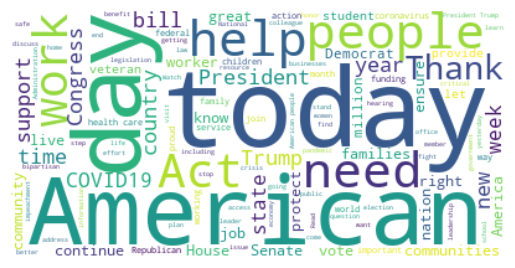

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Word cloud
text = ' '.join(sampled_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white", 
                        random_state=40
                     ).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2

In [10]:
#ScatterText
import scattertext as st

sampled_tweets['processed_text'] = sampled_tweets['tokens'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

corpus = st.CorpusFromPandas(sampled_tweets,              # specify data
                             category_col = 'party',   # specify the explanatory variable  as party 
                             text_col = 'processed_text',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build



In [11]:
print(len(sampled_tweets), len(corpus.get_df()))  # Check if lengths match


5000 4976


In [12]:
# create html document

# Ensure metadata matches the subset of sampled_tweets used for corpus
metadata = sampled_tweets.loc[corpus.get_df().index, 'tweet_id'].fillna("").astype(str)


html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,
                                       metadata=metadata)
                                       
# write html document to memory and open in browser
open("Tweet Sentiment.html", 'wb').write(html.encode('utf-8'))

2232833

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [13]:
# Pramila Jayapal: liberal, Andy Biggs: conservative

In [14]:
# create columns for polarity and subjectivity
sampled_tweets['polarity'] = sampled_tweets['processed_text'].map(lambda text: TextBlob(text).sentiment.polarity)

sampled_tweets['subjectivity'] = sampled_tweets['processed_text'].map(lambda text: TextBlob(text).sentiment.subjectivity)


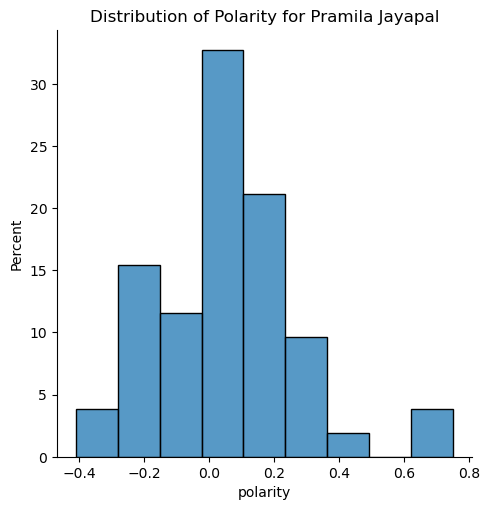

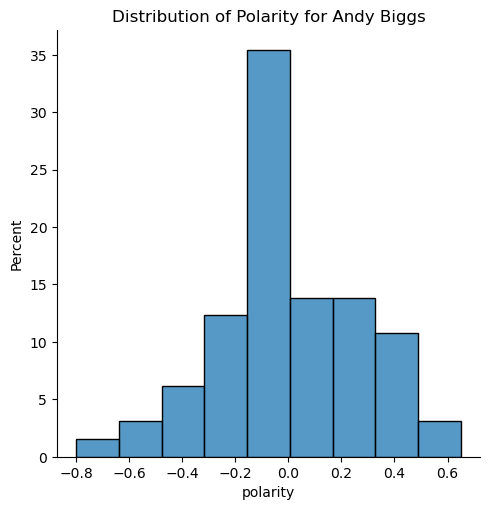

In [15]:

#Analysis for two legislators

# Pramila Jayapal
sns.displot(sampled_tweets[sampled_tweets['name_wikipedia'] == 'Pramila Jayapal'] ,            # specify data
            x="polarity",
           stat = "percent")    # specify x-axix feature 
plt.title("Distribution of Polarity for Pramila Jayapal")
plt.show()

#Andy Biggs
sns.displot(sampled_tweets[sampled_tweets['name_wikipedia'] == 'Andy Biggs'] ,            # specify data
            x="polarity",
           stat = "percent")    # specify x-axix feature 
plt.title("Distribution of Polarity for Andy Biggs")
plt.show()


These plots show that the more liberal legislator's tweets lean more positive and the more conservative legislator's tweets lean more negative. For both of them the majority of tweets are between -0.2 and 0.2, indicating that most tweets are closer to neutral polarity than the extremes. This is consistent with my expectation, particularly after seeing the ScatterText result, which showed that Democrats seem to talk more about substantive policy issues while Republicans talk more about people they don't like (i.e. Pelosi and Schiff), so I assumed Democrats would lean more positive and Republicans would lean more negative. 

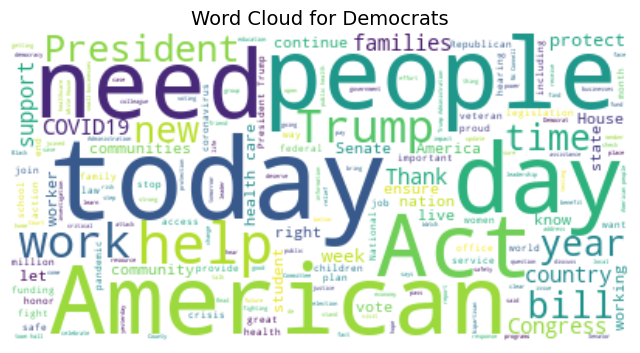

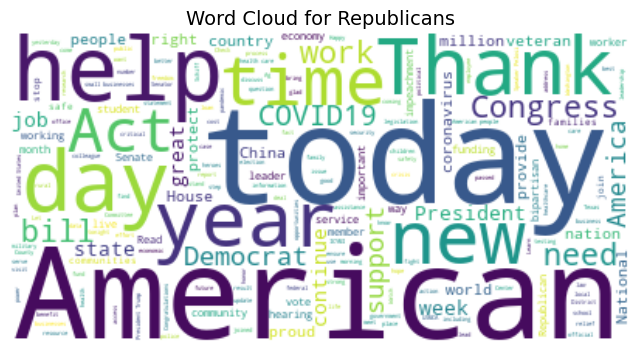

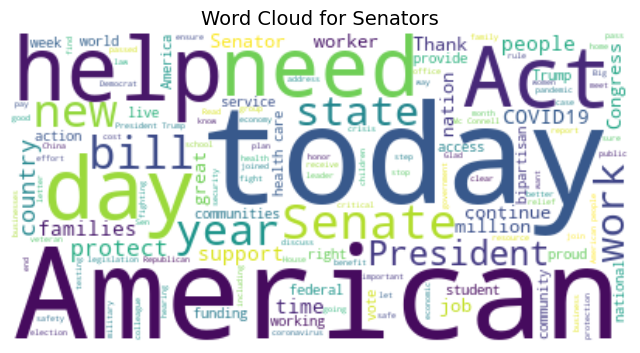

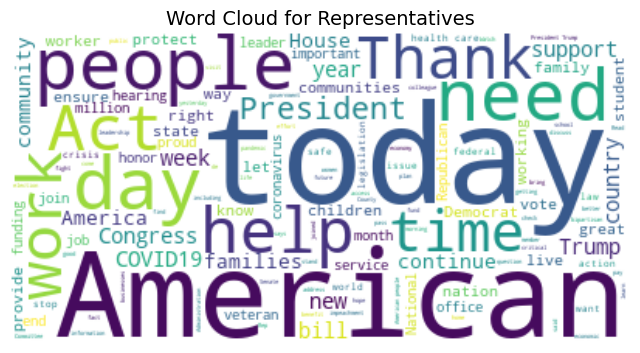

In [16]:
#Word clouds for dem v gop and senators v representatives
# Define filters
filters = {
    'Democrats': sampled_tweets[sampled_tweets['party'] == 'Democrat'],
    'Republicans': sampled_tweets[sampled_tweets['party'] == 'Republican'],
    'Senators': sampled_tweets[sampled_tweets['position'] == 'Sen'],
    'Representatives': sampled_tweets[sampled_tweets['position'] == 'Rep']
}

# Loop through each filter and generate word clouds
for label, df in filters.items():
    # Ensure 'tokens' column has valid data
    if 'tokens' in df.columns and not df['tokens'].isnull().all():
        text = ' '.join(df['tokens'].dropna().map(lambda text: ' '.join(text)))

        # Generate word cloud
        wordcloud = WordCloud(background_color="white", random_state=40).generate(text)

        # Plot the word cloud
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {label}", fontsize=14)
        plt.show()
    else:
        print(f"Skipping {label} due to missing or empty 'tokens' column.")




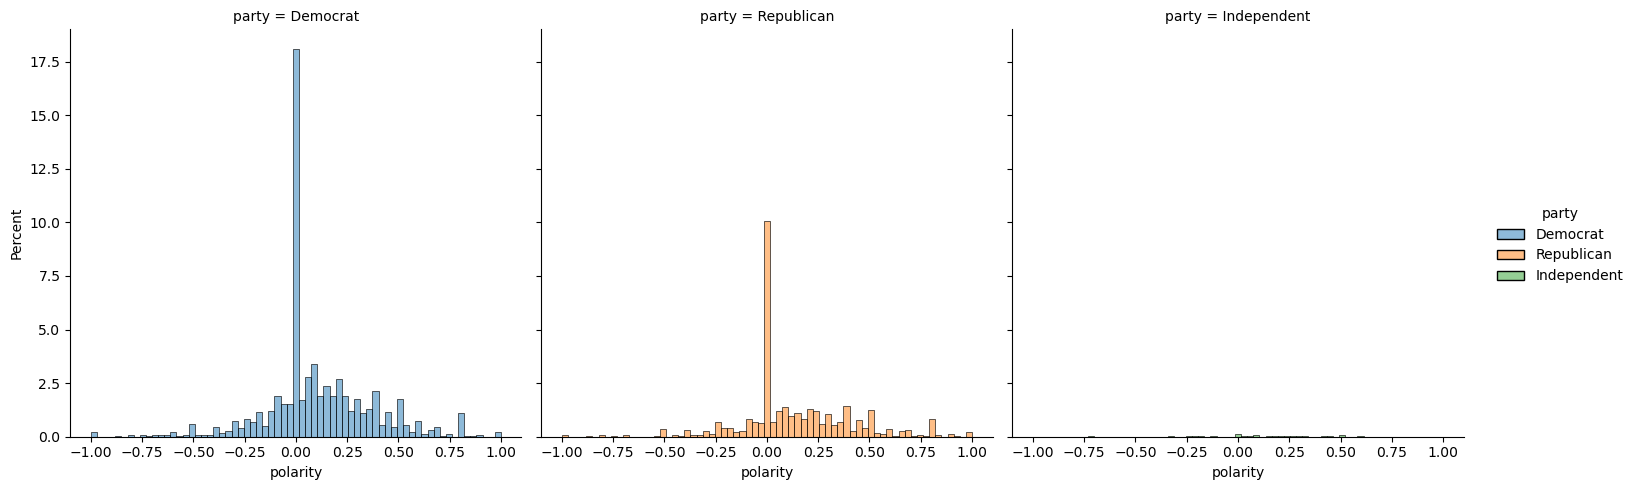

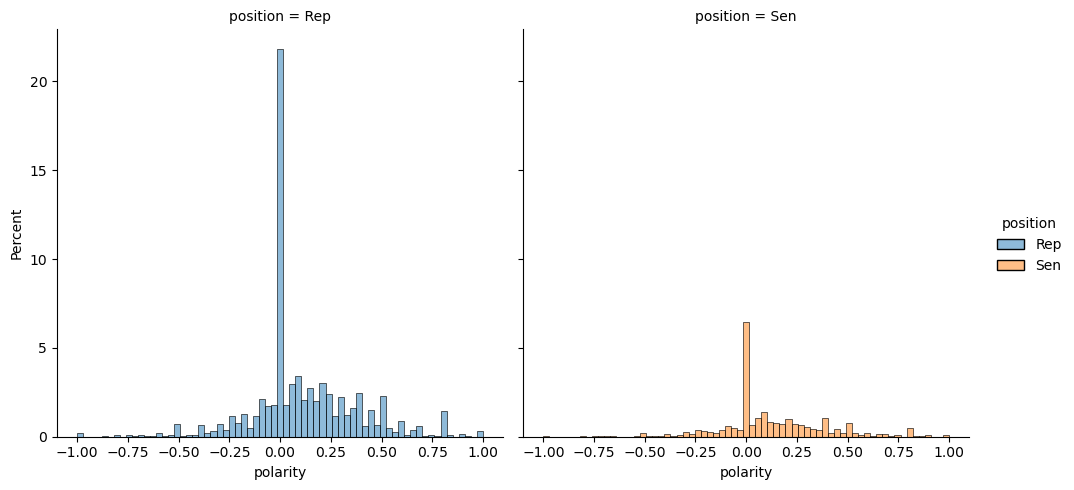

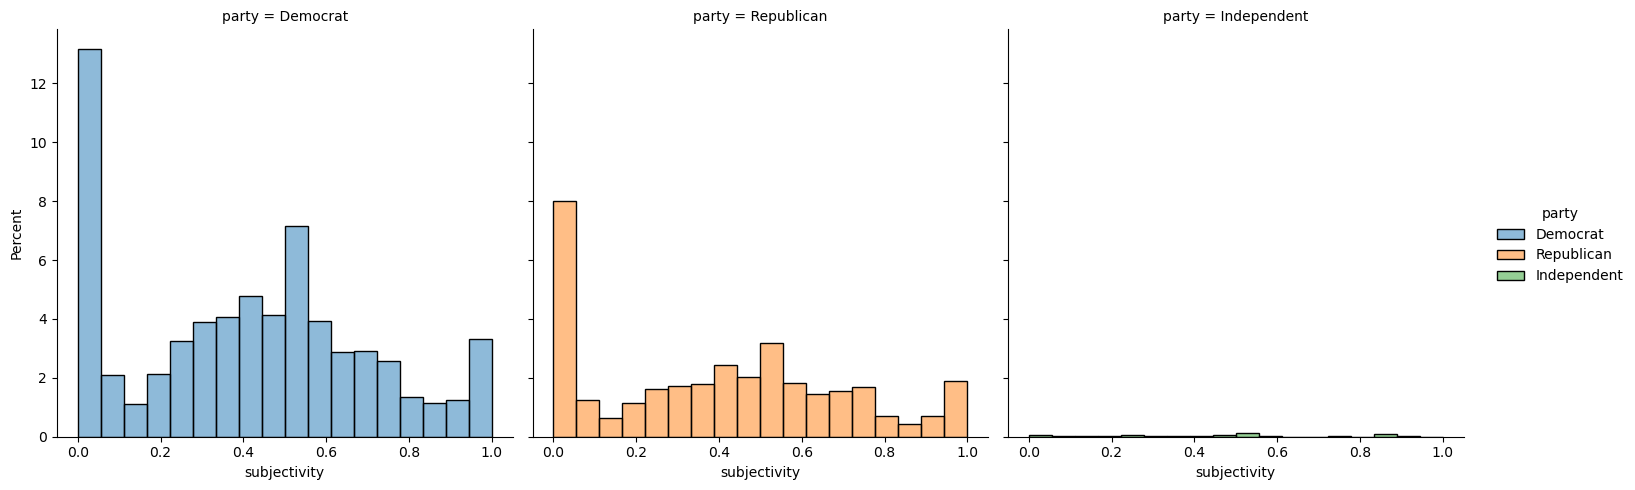

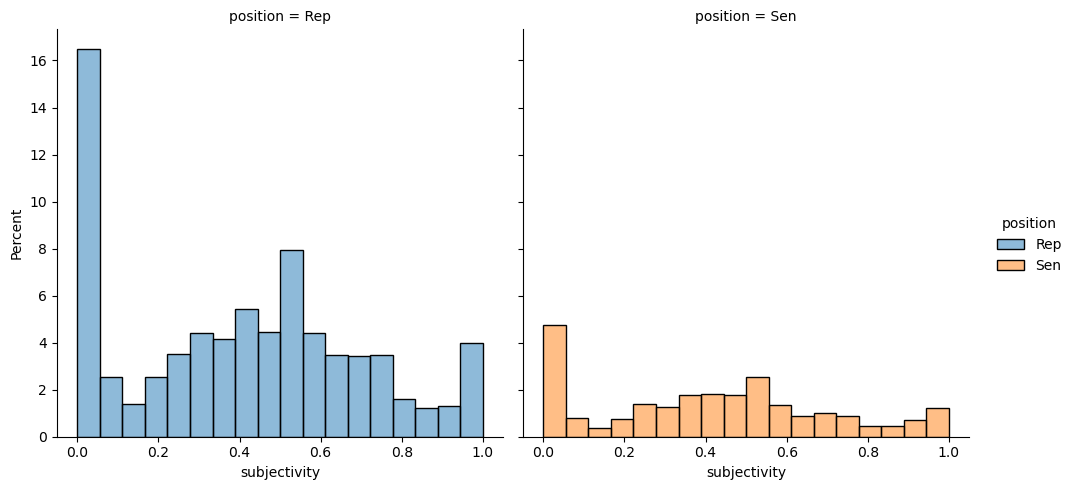

In [17]:
#Polarity for Dems v GOP
sns.displot(sampled_tweets,            # specify data
            x="polarity",
            hue = "party",
            col = "party",
           stat = "percent")    
plt.show()

#Polarity for Senators v Representatives

sns.displot(sampled_tweets,            # specify data
            x="polarity",
            hue = "position",
            col = "position",
           stat = "percent")    
plt.show()


#Subjectivity
sns.displot(sampled_tweets,            # specify data
            x="subjectivity",
            hue = "party",
            col = "party",
           stat = "percent")    
plt.show()


sns.displot(sampled_tweets,            # specify data
            x="subjectivity",
            hue = "position",
            col = "position",
           stat = "percent")    
plt.show()



## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [18]:
# Engineered Features
engineered_features = sampled_tweets[[
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)


### Bag-of-words or Tf-idf

In [19]:
# Frequency Based featurization
#tf-idf matrix
# initalize TfidfVectorizer and specify some parameters
# ----------

tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                               token_pattern = None)      # set to "None" since we have specify our own pattern to prevent error

# obtain matrix
tfidf_matrix = tfidf_vector.fit_transform(sampled_tweets['text'])


# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tfidf_vector.get_feature_names_out())  # set feature names


### Word Embedding

In [20]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [21]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    words = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(words) == 0:  # Ensure there are words in the document
        return np.zeros(word2vec_model.vector_size)  # Return a zero vector instead of an empty list
    return np.mean([word2vec_model.wv[word] for word in words], axis=0)

In [22]:
# embedding based featurization
word2vec_model = gensim.models.Word2Vec(sampled_tweets['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

document_vectors = np.array([document_vector(word2vec_model, doc) for doc in sampled_tweets['tokens']]) #convert documents into vectors


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [23]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

#features defined as: engineered_features, tfidf_matrix, document_vectors

#Use logit model
from sklearn.linear_model import LogisticRegression

#define targets
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

sampled_tweets['party_clean'] = sampled_tweets['party'].replace({'Independent': 'Democrat'}) #define Independents as Democrats to make classification cleaner
Y1 = sampled_tweets['party_clean_binary'] = lb.fit_transform(sampled_tweets['party_clean']).ravel() #Y1 : target for party classification
Y2 = sampled_tweets['position_binary'] = lb.fit_transform(sampled_tweets['position']).ravel() #Y2: target for position classification

targets = [Y1,
          Y2]

#target labels
target_var = ['Party',
              'Position']

#dataframes
dataframes = [engineered_features, 
              tfidf_df,
             document_vectors]

#labels
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                           'Embedding Based Features']


In [24]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

#loop to run six models
# Initialize results storage
results = []

# Loop through each target variable
for i, Y in enumerate(targets):  
    target_name = target_var[i]
    
    # Loop through each feature set
    for j, X in enumerate(dataframes):
        feature_name = featurization_technique[j]

        print(f"\nTraining with Target: {target_name} and Featurization: {feature_name}")
    
        # Train-test split (80% train, 20% test)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5, stratify=Y)
        
        # Train logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=1)
        model.fit(X_train, Y_train.ravel())  # Ensure Y is correctly shaped
        
        # Make predictions
        Y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average='weighted')
        recall = recall_score(Y_test, Y_pred, average='weighted')
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        
        # Store results
        results.append({
            "Target": target_name,
            "Featurization": feature_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


Training with Target: Party and Featurization: Engineered Text Features

Training with Target: Party and Featurization: Tf-idf Features


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with Target: Party and Featurization: Embedding Based Features

Training with Target: Position and Featurization: Engineered Text Features

Training with Target: Position and Featurization: Tf-idf Features


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training with Target: Position and Featurization: Embedding Based Features
     Target             Featurization  Accuracy  Precision  Recall  F1 Score
0     Party  Engineered Text Features     0.659   0.434281   0.659  0.523546
1     Party           Tf-idf Features     0.687   0.683596   0.687  0.615846
2     Party  Embedding Based Features     0.659   0.434281   0.659  0.523546
3  Position  Engineered Text Features     0.758   0.574564   0.758  0.653656
4  Position           Tf-idf Features     0.767   0.800188   0.767  0.676035
5  Position  Embedding Based Features     0.758   0.574564   0.758  0.653656


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Two Combined Models

In [25]:
#get non-text columns
print(sampled_tweets.columns.values)

['tweet_id' 'screen_name' 'datetime' 'text' 'name_wikipedia' 'position'
 'joined_congress_date' 'birthday' 'gender' 'state' 'district_number'
 'party' 'trump_2016_state_share' 'clinton_2016_state_share'
 'obama_2012_state_share' 'romney_2012_state_share' 'tokens'
 'processed_text' 'polarity' 'subjectivity' 'party_clean'
 'party_clean_binary' 'position_binary']


In [26]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

non_text = sampled_tweets[['state',
                            'gender',
                            'birthday']]  #I imagine state will be very predictive of party, and gender/birthday will be predictive of position

non_text_dummies = pd.get_dummies(non_text).reset_index(drop = True)
non_text_plus_tfidf = non_text_dummies.reset_index(drop = True).join(tfidf_df)

dataframes = [non_text_dummies,
              non_text_plus_tfidf]

featurization_technique = ['Non-Text Features',
                           'Non-Text and Text Features']
    

# Initialize results storage
results2 = []

# Loop through each target variable
for i, Y in enumerate(targets):  
    target_name = target_var[i]
    
    # Loop through each feature set
    for j, X in enumerate(dataframes):
        feature_name = featurization_technique[j]

        # Train-test split (80% train, 20% test)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5, stratify=Y)
        
        # Train logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=1)
        model.fit(X_train, Y_train.ravel())  # Ensure Y is correctly shaped
        
        # Make predictions
        Y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average='weighted')
        recall = recall_score(Y_test, Y_pred, average='weighted')
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        
        # Store results
        results2.append({
            "Target": target_name,
            "Featurization": feature_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results2)

# Display results
print(results_df)




     Target               Featurization  Accuracy  Precision  Recall  F1 Score
0     Party           Non-Text Features     0.989   0.989053   0.989  0.988972
1     Party  Non-Text and Text Features     0.982   0.982088   0.982  0.981934
2  Position           Non-Text Features     0.998   0.998005   0.998  0.997997
3  Position  Non-Text and Text Features     0.997   0.997012   0.997  0.996994


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Text can present in many different ways that go beyond what can be covered in standard preprocessing techniques. In this case, we have text from tweets, where use of text is different than, for example, a policy brief. Specific to twitter we know that people use emojis to communicate. They also may tag someone in their post using @ and the handle. They may retweet others, meaning RT and QT come up in the text. It is up to us as analysts to identify the specific patterns of the text we are using that go beyond standard text preprocessing. In addition, some of these specific dynamics require the analyst to make decisions. For example, I decided to remove RT, QT and tagging of other handles. It is possible, though, that retweeting someone can indicate endorsement or disagreement depending on the rest of the context of the tweet. In my analysis, the text of retweets is treated the same as the text of normal tweets. Other analysts may make different decisions based on the assumptions brought to the data. All of this is to say that the specific corpus and the question of interest will have significant bearing on processing the text before analysis. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

I did find some evidence of this. In particular, I find the scattertext graphic to be very informative. Here we can see separating words between the parties. This shows that Democrats talk about issues like gun violence, climate change, DACA, LGBTQ, and Republicans talk about people they don't like (Speaker Pelosi and Adam Schiff). We can also see the red states i.e. Arkansas, Idaho, the Dakotas in Republicans tweets and blue states i.e. California in Democrats tweets. 

In order to interpret sentiment using polarity and subjectivity, I print summary stats here.

In [27]:
#summary statistics
summary_stats = {}

for name, subset in filters.items():
    summary_stats[name] = subset[['polarity', 'subjectivity']].describe()

# Display the results
for key, value in summary_stats.items():
    print(f"Summary for {key}:\n", value, "\n")

Summary for Democrats:
           polarity  subjectivity
count  3261.000000   3261.000000
mean      0.103701      0.405393
std       0.264697      0.290243
min      -1.000000      0.000000
25%       0.000000      0.155556
50%       0.034091      0.416667
75%       0.250000      0.600000
max       1.000000      1.000000 

Summary for Republicans:
           polarity  subjectivity
count  1705.000000   1705.000000
mean      0.135265      0.393685
std       0.276036      0.303410
min      -1.000000      0.000000
25%       0.000000      0.100000
50%       0.050000      0.400000
75%       0.300000      0.605556
max       1.000000      1.000000 

Summary for Senators:
           polarity  subjectivity
count  1212.000000   1212.000000
mean      0.129540      0.406303
std       0.265155      0.290610
min      -1.000000      0.000000
25%       0.000000      0.197917
50%       0.068182      0.400000
75%       0.270357      0.600000
max       1.000000      1.000000 

Summary for Representatives:
 

I haven't run any hypothesis tests to see if these means represent statistically significant differences. But these results are suggestive of:
Republicans are generally more positive in their tweets but there is more variation amongst the party than Democrats. 
Democrats are slightly more subjective in their tweets than Republicans. 
Senators are generally more positive in their tweets than Representatives.
Senators and Representatives are not very different in their subjectivity. 

In total, is suggestive that there is more difference in tweets between Republicans and Democrats than there are between Senators and Representatives, indicating that party polarization may be more substantial. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

By definition, supervised learning is connected to a ground truth so that models can be tested for accuracy (and related metrics) in order to see how well they're performing, while unsupervised approaches can highlight underlying patterns in the data but there is no specific validation that can be done to see if the unsupervised technique is performing well. Therefore using a supervised learning algorithm to validate unsupervised learning approaches can help to identify how well the unsupervised model is performing on certain metrics and get a better understanding of how well the unsupervised model would perform with out of sample data. This allows for potential refinement of the unsupervised method. Unsupervised methods can also intersect with supervised learning by helping to identify important features of the data which can be helpful for dimensionality reduction on the feature set. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

My model with non-text features only performed best.

Combining text and non-text features in a supervised learning algorithm allows for learning on context beyond the text itself that is contained in the non-text features. This allows for better generalizability given the potential for overfitting based on text alone. 